# Lesson 15.1 学习率调度基本概念与手动实现方法

学习率调整的场景：

- 缓解Dead ReLU Problem      
&emsp;&emsp;在ReLU激活函数叠加的神经网络中，由于ReLU本身负值归零的特性，可能会出现Dead ReLU Problem，我们可以通过减小学习率来降低模型落入活性失效陷进的概率。不过降低学习率也代表模型收敛速度更慢

- 提升模型表现      
&emsp;&emsp;学习率绝对数值的调整过程中，学习率对模型性能的影响整体呈现U型特征，即学习率过大或者过小都不好，学习过大可能会导致模型无法穿越狭窄的通道最终抵达最小值点，而学习率太小则容易在最小值点附近停止收敛，因此在进行模型训练时，我们需要找到一个适中的准确率取值

**学习率的设置**
- 模型学习率设置太大
  - 虽然前期收敛速度较快
  - 但容易出现收敛过程不稳定、收敛结果不佳、或者神经元活性失效等问题
- 学习率设置太小
  - 虽然收敛过程将相对平稳，并且能够有效规避神经元活性坏死的问题
  - 但容易出现收敛速度慢、收敛结果不佳等问题。

### 一、学习率对模型训练影响

- 学习率较大的模型收敛速度较快，但效果却不一定最好
- 学习率非常小的模型不仅收敛速度较慢，并且效果也不尽如人意
- `A.extend(B)` 用于在列表A末尾一次性追加另一个序列B中的多个值

In [1]:
# 设置随机数种子
torch.manual_seed(420)  

# 创建最高项为2的多项式回归数据集
features, labels = tensorGenReg(w=[2, -1, 3, 1, 2], bias=False, deg=2)

# 进行数据集切分与加载
train_loader, test_loader = split_loader(features, labels, batch_size=50)

In [2]:
# 设置随机数种子
torch.manual_seed(24)  

# 关键参数
num_epochs = 20

# 实例化模型  tanh为激活函数
tanh_model1 = net_class2(act_fun = torch.tanh, in_features=5, BN_model='pre')
tanh_model2 = net_class2(act_fun = torch.tanh, in_features=5, BN_model='pre')
tanh_model3 = net_class2(act_fun = torch.tanh, in_features=5, BN_model='pre')
tanh_model4 = net_class2(act_fun = torch.tanh, in_features=5, BN_model='pre')

In [3]:
#————————————————————————4组模型只有学习率不同————————————————————————
# tanh_model进行模型训练
train_l1, test_l1 = model_train_test(tanh_model1, 
                                     train_loader,
                                     test_loader,
                                     num_epochs = num_epochs, 
                                     criterion = nn.MSELoss(), 
                                     optimizer = optim.SGD, 
                                     lr = 0.03, 
                                     cla = False, 
                                     eva = mse_cal)

train_l2, test_l2 = model_train_test(tanh_model2, 
                                     train_loader,
                                     test_loader,
                                     num_epochs = num_epochs, 
                                     criterion = nn.MSELoss(), 
                                     optimizer = optim.SGD, 
                                     lr = 0.01, 
                                     cla = False, 
                                     eva = mse_cal)

train_l3, test_l3 = model_train_test(tanh_model3, 
                                     train_loader,
                                     test_loader,
                                     num_epochs = num_epochs, 
                                     criterion = nn.MSELoss(), 
                                     optimizer = optim.SGD, 
                                     lr = 0.005, 
                                     cla = False, 
                                     eva = mse_cal)

train_l4, test_l4 = model_train_test(tanh_model4, 
                                     train_loader,
                                     test_loader,
                                     num_epochs = num_epochs, 
                                     criterion = nn.MSELoss(), 
                                     optimizer = optim.SGD, 
                                     lr = 0.001, 
                                     cla = False, 
                                     eva = mse_cal)

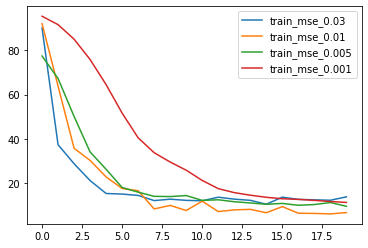

In [4]:
plt.plot(list(range(num_epochs)), train_l1, label='train_mse_0.03')
plt.plot(list(range(num_epochs)), train_l2, label='train_mse_0.01')
plt.plot(list(range(num_epochs)), train_l3, label='train_mse_0.005')
plt.plot(list(range(num_epochs)), train_l4, label='train_mse_0.001')
plt.legend(loc = 1)

# 学习率较大的模型收敛速度较快，但效果却不一定最好
# 而学习率非常小的模型不仅收敛速度较慢，并且效果也不尽如人意。

在实际生产生活中，训练一个模型已经是非常耗费时间的了，为了一个超参数同时训练多组模型并不划算。而要通过学习率数值调整来让模型“又好又快”的收敛，就需要采用一种名为学习率调度的优化算法。

## 二、学习率调度基本概念与手动实现方法

### 1.学习率调度基本概念

先让学习率取得较大数值，从而能够让模型在最开始能够以较快的速度收敛；然后在经过一段时间迭代之后，将学习率调小，从而能够让收敛过程穿过损失函数的“隘口”，抵达更小的解。

### 2.手动实现学习率调度

- 利用input函数输入epoch,lr

#### 2.1 本地实现方法

我们可以借助Python中的input函数来手动实现学习率伴随迭代epoch次数的动态调整，具体操作方法如下：

In [5]:
# 实例化模型
# 设置随机数种子
torch.manual_seed(24)  

# 实例化模型  
tanh_model = net_class2(act_fun=torch.tanh, in_features=5, BN_model='pre')

- 更新fit函数  
&emsp;&emsp;接下来我们对fit函数进行更新，在原有fit函数基础上加上每一轮迭代后模型评估结果的记录功能。

In [6]:
def fit_rec(net, 
            criterion, 
            optimizer, 
            train_data,
            test_data,
            epochs = 3, 
            cla = False, 
            eva = mse_cal):
    """模型训练函数（记录每一次遍历后模型评估指标）
    
    :param net：待训练的模型 
    :param criterion: 损失函数
    :param optimizer：优化算法
    :param train_data：训练数据
    :param test_data: 测试数据 
    :param epochs: 遍历数据次数
    :param cla: 是否是分类问题
    :param eva: 模型评估方法
    :return：模型评估结果
    """
    train_l = []
    test_l = []
    
    for epoch  in range(epochs):
        net.train()
        for X, y in train_data:
            if cla == True:
                y = y.flatten().long()          # 如果是分类问题，需要对y进行整数转化
            yhat = net.forward(X)
            loss = criterion(yhat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        net.eval()
        train_l.append(eva(train_data, net).detach())
        test_l.append(eva(test_data, net).detach())
        # 返回每epoch的训练误差和测试误差
    return train_l, test_l

In [7]:
#——————————————————————————测试函数性能——————————————————————————
fit_rec(net = tanh_model, 
        criterion = nn.MSELoss(), 
        optimizer = optim.SGD(tanh_model.parameters(), lr = 0.03), 
        train_data = train_loader,
        test_data = test_loader,
        epochs = 3, 
        cla = False, 
        eva = mse_cal)

([tensor(37.9793), tensor(32.4801), tensor(30.2007)],
 [tensor(37.7321), tensor(33.3702), tensor(32.1592)])

- 手动动态调整过程

&emsp;&emsp;接下来，我们尝试借助Python中的input函数功能，来执行手动动态调整模型训练过程中的学习率。

In [8]:
# 设置随机数种子
torch.manual_seed(24)  

# 实例化模型  
tanh_model = net_class2(act_fun=torch.tanh, in_features=5, BN_model='pre')

In [9]:
#———————————————————————————第一个模型————————————————————————————
# 创建用于保存记录结果的空列表容器
train_mse = []
test_mse = []

# 创建可以捕捉手动输入数据的模型训练流程
while input("Do you want to continue the iteration? [y/n]") == "y":    # 询问是否继续迭代
    epochs = int(input("Number of epochs:"))                           # 下一轮迭代遍历几次数据
    lr = float(input("Update learning rate："))                        # 设置下一轮迭代的学习率
    train_l, test_l = fit_rec(net = tanh_model, 
                              criterion = nn.MSELoss(), 
                              optimizer = optim.SGD(tanh_model.parameters(), lr = lr), 
                              train_data = train_loader,
                              test_data = test_loader,
                              epochs = epochs, 
                              cla = False, 
                              eva = mse_cal)
    train_mse.extend(train_l)
    test_mse.extend(test_l)
    
# `A.extend(B)` 用于在列表A末尾一次性追加另一个序列B中的多个值

# 每次输入 是否迭代 -> num_epochs -> lr
#  y  -> 30 -> 0.03 -> y -> 30 -> 0.01 -> n

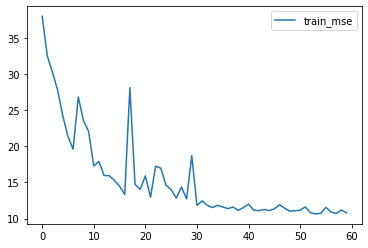

In [10]:
# 查看模型训练结果
plt.plot(train_mse, label='train_mse')
plt.legend(loc = 1)

In [11]:
# 以0.03作为学习率迭代60个epochs，对比模型训练效果
# 设置随机数种子
torch.manual_seed(24)  

# 实例化模型  
tanh_model = net_class2(act_fun=torch.tanh, in_features=5, BN_model='pre')

In [12]:
#———————————————————————————第二个模型- 以0.03作为学习率迭代60个epochs———————————————————————————
# 创建用于保存记录结果的空列表容器
train_msel = []
test_msel = []

# 创建可以捕捉手动输入数据的模型训练流程
while input("Do you want to continue the iteration? [y/n]") == "y":    # 询问是否继续迭代
    epochs = int(input("Number of epochs:"))                           # 下一轮迭代遍历几次数据
    lr = float(input("Update learning rate："))                        # 设置下一轮迭代的学习率
    train_l, test_l = fit_rec(net = tanh_model, 
                              criterion = nn.MSELoss(), 
                              optimizer = optim.SGD(tanh_model.parameters(), lr = lr), 
                              train_data = train_loader,
                              test_data = test_loader,
                              epochs = epochs, 
                              cla = False, 
                              eva = mse_cal)
    train_msel.extend(train_l)
    test_msel.extend(test_l)

    # y 60 0.03 n

Text(0.5, 0, 'epochs')

Text(0, 0.5, 'MSE')

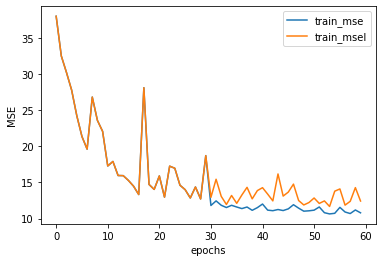

In [13]:
plt.plot(train_mse, label='train_mse')
plt.plot(train_msel, label='train_msel')
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.legend(loc = 1)

# 手动调整模型学习率的第一个模型在最终模型表现上比第二个模型更好
# 在同样遍历了60次的情况下，模型一能够收敛至一个更小的MSE。

In [14]:
#———————————————————————————学习率为0.01———————————————————————————
# 设置随机数种子
torch.manual_seed(24)  

# 实例化模型  
tanh_model = net_class2(act_fun=torch.tanh, in_features=5, BN_model='pre')


In [15]:
# 创建用于保存记录结果的空列表容器
train_mses = []
test_mses = []

# 创建可以捕捉手动输入数据的模型训练流程
while input("Do you want to continue the iteration? [y/n]") == "y":    # 询问是否继续迭代
    epochs = int(input("Number of epochs:"))                           # 下一轮迭代遍历几次数据
    lr = float(input("Update learning rate："))                        # 设置下一轮迭代的学习率
    train_l, test_l = fit_rec(net = tanh_model, 
                              criterion = nn.MSELoss(), 
                              optimizer = optim.SGD(tanh_model.parameters(), lr = lr), 
                              train_data = train_loader,
                              test_data = test_loader,
                              epochs = epochs, 
                              cla = False, 
                              eva = mse_cal)
    train_mses.extend(train_l)
    test_mses.extend(test_l)

Text(0.5, 0, 'epochs')

Text(0, 0.5, 'MSE')

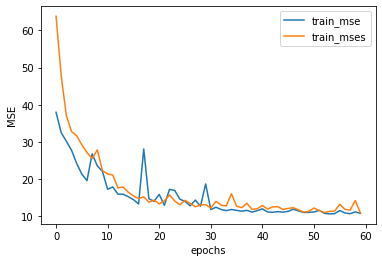

In [16]:
plt.plot(train_mse, label='train_mse')
plt.plot(train_mses, label='train_mses')
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.legend(loc = 1)

# 我们能够发现，第一个模型收敛速度明显快于第二个模型，
# 据此也能说明手动调整模型学习率的有效性。

#### 2.2 配合tensorboard实现方法


tensorboard中writer对象却能够即时记录模型中间结果，并且同步呈现在tensorboard的操作面板上。借此功能，我们便能将在某个cell尚未运行结束之前看到当前阶段的运行结果。要完成该过程，则需要在此前代码基础之上进行修改。

- `writer = SummaryWriter(log_dir='l3')`  实例化 
  - log_dir (string): Save directory location
- `writer.add_scalar('变量名', y, x)`  添加数据
  - 

In [24]:
SummaryWriter?

Init signature:
SummaryWriter(
    log_dir=None,
    comment='',
    purge_step=None,
    max_queue=10,
    flush_secs=120,
    filename_suffix='',
)
Docstring:     
Writes entries directly to event files in the log_dir to be
consumed by TensorBoard.

The `SummaryWriter` class provides a high-level API to create an event file
in a given directory and add summaries and events to it. The class updates the
file contents asynchronously. This allows a training program to call methods
to add data to the file directly from the training loop, without slowing down
training.
Init docstring:
Creates a `SummaryWriter` that will write out events and summaries
to the event file.

Args:
    log_dir (string): Save directory location. Default is
      runs/**CURRENT_DATETIME_HOSTNAME**, which changes after each run.
      Use hierarchical folder structure to compare
      between runs easily. e.g. pass in 'runs/exp1', 'runs/exp2', etc.
      for each new experiment to compare across them.
    comment (

In [17]:
#———————————————————————zip函数————————————————————————
l1 = list(range(10))
l1

l1[3:5]

l2 = list(range(1, 3))
l2

for i, j in zip(l2, l1[3:5]):
    print(i, j)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

[3, 4]

[1, 2]

1 3
2 4


In [18]:
# 设置随机数种子
torch.manual_seed(24)  

# 实例化模型  
tanh_model = net_class2(act_fun= torch.tanh, in_features=5, BN_model='pre')

In [19]:
# 实例化writer对象
writer = SummaryWriter(log_dir='l3')

# 创建空列表容器
train_mse = []
test_mse = []

# 创建总遍历次数计数器
num_epochs = 0

提前打开tensorboard服务，在命令行中输入
```shell
F:
cd "F:\Code File\PyTorch实战\"
tensorboard --logdir="l3"
```

In [20]:
while input("Do you want to continue the iteration? [y/n]") == "y":
    epochs = int(input("Number of epochs:"))
    lr = float(input("Update learning rate："))
    train_l, test_l = fit_rec(net = tanh_model, 
                              criterion = nn.MSELoss(), 
                              optimizer = optim.SGD(tanh_model.parameters(), lr = lr), 
                              train_data = train_loader,
                              test_data = test_loader,
                              epochs = epochs, 
                              cla = False, 
                              eva = mse_cal)
    train_mse.extend(train_l)
    test_mse.extend(test_l)
    for i, j in zip(list(range(num_epochs, num_epochs+epochs)), train_mse[num_epochs: num_epochs+epochs]):
        writer.add_scalar('train_mse', j, i)
    for i, j in zip(list(range(num_epochs, num_epochs+epochs)), test_mse[num_epochs: num_epochs+epochs]):
        writer.add_scalar('test_mse', j, i)
    num_epochs += epochs

# y 30 0.03 y 30 0.01 n

当我们执行完第一阶段的30次遍历之后，我们即可打开浏览器输入`localhost:6006`查看当前记录的模型MSE情况。


--- 

值得注意的是，当我们在使用add_scalar进行数据记录时，绘制折线图的横纵坐标都是必须的，如果缺失了横坐标，tensorboard中图像绘制的最终结果将呈现一条竖线。

In [21]:
for i in range(10):
    writer.add_scalar('i',i)

# 图i中，缺失横坐标

---

In [22]:
num_epochs          # 上一轮循环截止时总共遍历多少次数据

0

我们再遍历30次数据，并设置学习率为0.005进行模型训练，测试代码性能与模型效果

In [23]:
#—————————————————遍历30次数据 学习率为0.005————————————————

while input("Do you want to continue the iteration? [y/n]") == "y":
    epochs = int(input("Number of epochs:"))
    lr = float(input("Update learning rate："))
    train_l, test_l = fit_rec(net = tanh_model, 
                              criterion = nn.MSELoss(), 
                              optimizer = optim.SGD(tanh_model.parameters(), lr = lr), 
                              train_data = train_loader,
                              test_data = test_loader,
                              epochs = epochs, 
                              cla = False, 
                              eva = mse_cal)
    train_mse.extend(train_l)
    test_mse.extend(test_l)
    for i, j in zip(list(range(num_epochs, num_epochs+epochs)), train_mse[num_epochs: num_epochs+epochs]):
        writer.add_scalar('train_mse', j, i)
    for i, j in zip(list(range(num_epochs, num_epochs+epochs)), test_mse[num_epochs: num_epochs+epochs]):
        writer.add_scalar('test_mse', j, i)
    num_epochs += epochs

# y 30 0.005 n
# 在tensorboard页面中查看总共90轮epochs的训练结果


至此，我们就完成了学习率手动调度实验。在上述操作流程中，我们不仅可以即时调整每一次训练遍历数据集的次数、同时灵活设置该训练过程的学习率，并且能够借助tensorboard即时呈现模型训练结果。

### 3.常用学习率调度思路

伴随模型遍历数据集次数增加、学习率逐渐降低，能够使得模型整体性能有所提升。

- 幂调度：        
&emsp;&emsp;随着迭代次数增加，学习率呈现幂律变化，
  - 例如，$lr$为初始（第一轮）学习率，第二轮迭代时学习率调整为$lr/2$，第三轮迭代时学习率调整为$lr/3$等；

- 指数调度：      
&emsp;&emsp;随着迭代次数增加，学习率呈现指数变化，
  - 例如，$lr$为初始（第一轮）学习率，第二轮迭代时学习率调整为$lr/10^1$，第三轮迭代时学习率调整为$lr/10^2 = lr/100$等

- 分段恒定调度：      
&emsp;&emsp;即每隔几轮迭代调整一次学习率，
  - 例如1-10轮学习率为$lr$，10-20轮时学习率为$lr/100$等，不难发现此前我们所做的实验就是一种特殊的分段恒定调度策略； 

- 性能调度：      
&emsp;&emsp;即每隔一段时间观察误差变化情况，如果误差基本不变，则降低学习率继续迭代；

- 周期调度：      
&emsp;&emsp;和前面几种学习率调度策略一味将学习率递减有所不同，周期调度允许学习率在一个周期内进行先递增后递减的变化